# Anomaly detection in Time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

### Read the data

This is the real-life data on CPU utilization of an EC2 instance in the AWS cloud. Data was recorder every 5 minutes, starting on February 14th at the 14:30.
The dataset contains 4032 data points. It is available through the Numenta Anomaly Benchmark (NAB) repository under the AGPL-3.0 license.


Labels can be downloaded on [GitHub](https://github.com/numenta/NAB/blob/master/labels/combined_labels.json)

In [3]:

df = pd.read_csv('ec2_cpu_utilization.csv')
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [4]:
# Labels taken from the link above.

anomalies_timestamp = [
    "2014-02-26 22:05:00",
    "2014-02-27 17:15:00"
]

In [5]:
#Convert to timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])

df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [6]:
# Add an anomaly label

df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [7]:

anomaly_df = df.loc[df["is_anomaly"] == -1]
inlier_df = df.loc[df["is_anomaly"] == 1]

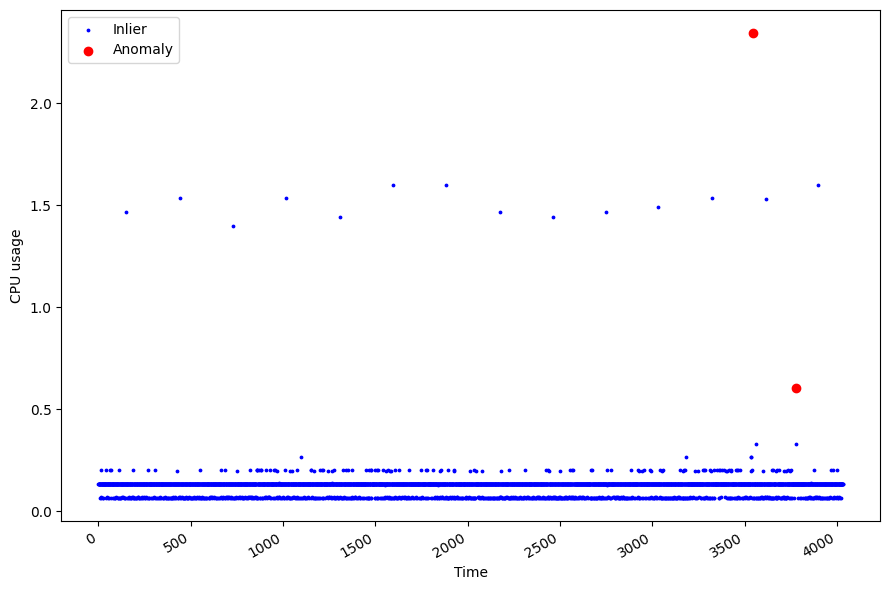

In [8]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color = 'blue', s = 3, label = 'Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color = 'red', label = 'Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc = 2)


fig.autofmt_xdate()
fig.tight_layout()

## 1 Method. Robust Z-score (Median absolute deviation)

When the data is normally distributed, we can conclude that points at each tail are outliers. And Z-score can tell us if our point are outlier or not

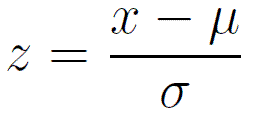

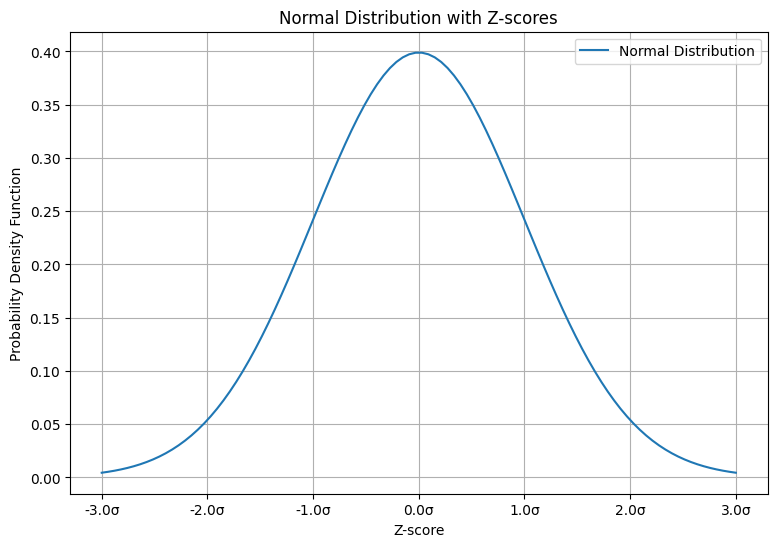

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


mu, sigma = 0, 1  
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)


plt.plot(x, y, label='Normal Distribution')


z_scores = np.arange(-3, 4, 1)
z_values = mu + z_scores * sigma
plt.xticks(z_values, [f'{z:.1f}σ' for z in z_scores])


plt.xlabel('Z-score')
plt.ylabel('Probability Density Function')
plt.title('Normal Distribution with Z-scores')


plt.legend()
plt.grid(True)
plt.show()


🚨 The presence of outliers affect the mean, and therefore the Z-score! So we will use median instead of the mean

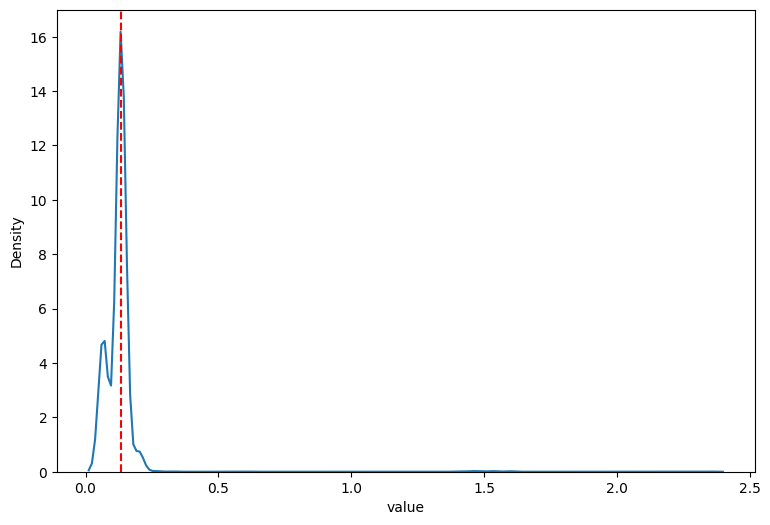

In [10]:
## plotting the distribution of our data
import seaborn as sns

sns.kdeplot(df['value'])

median_value = df['value'].median()
plt.axvline(median_value, 0, 1, color='red', linestyle='dashed',)

In [11]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

def compute_robust_z_score(x):
    return .6745 * (x-median)/mad 

df["z-score"] = df['value'].apply(compute_robust_z_score)

df.head()


,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [12]:
#Determine if its anomaly (use a threshold of 3.5)
df["baseline"] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <= -3.5, 'baseline'] = -1

### Evaluation

False Positive Rate: 1.0000
Precision Rate: 0.7355


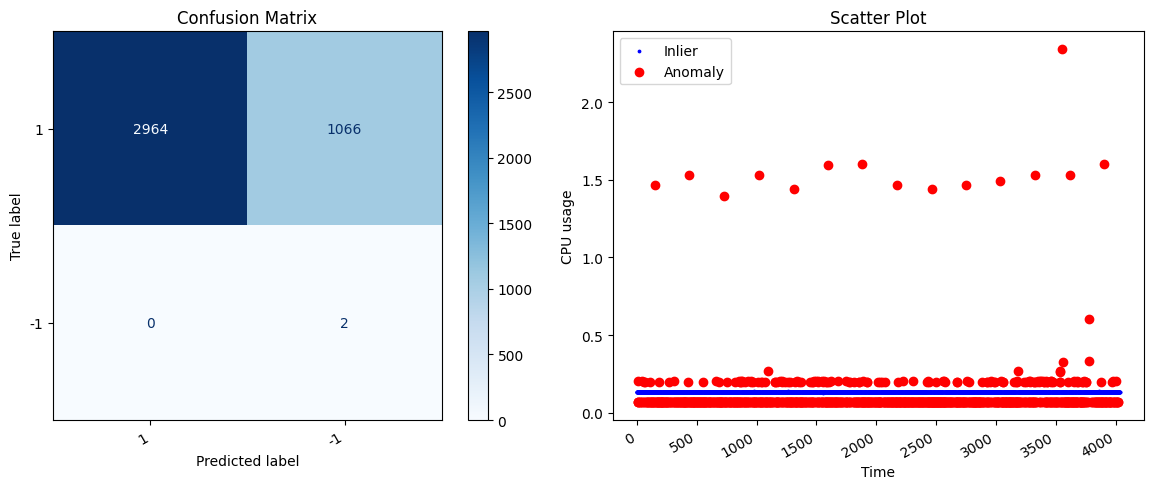

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, -1])

disp_cm.plot(cmap='Blues', ax=ax1[0], values_format='.5g')
ax1[0].set_title('Confusion Matrix')

# Plot scatter plot
anomaly_df = df.loc[df["baseline"] == -1]
inlier_df = df.loc[df["baseline"] == 1]

ax2 = ax1[1]
ax2.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax2.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax2.set_xlabel('Time')
ax2.set_ylabel('CPU usage')
ax2.legend(loc=2)
ax2.set_title('Scatter Plot')

# Adjust layout
fig.autofmt_xdate()
fig.tight_layout()

TP = cm[0, 0]
FN = cm[1, 1]
FP = cm[0, 1]  
TN = cm[1, 0]  
FPR = FP / (FP + TN)
Precision = TP / (TP + FP)

print(f"False Positive Rate: {FPR:.4f}")
print(f"Precision Rate: {Precision:.4f}")


## Isolation Forest

In [14]:
from sklearn.ensemble import IsolationForest

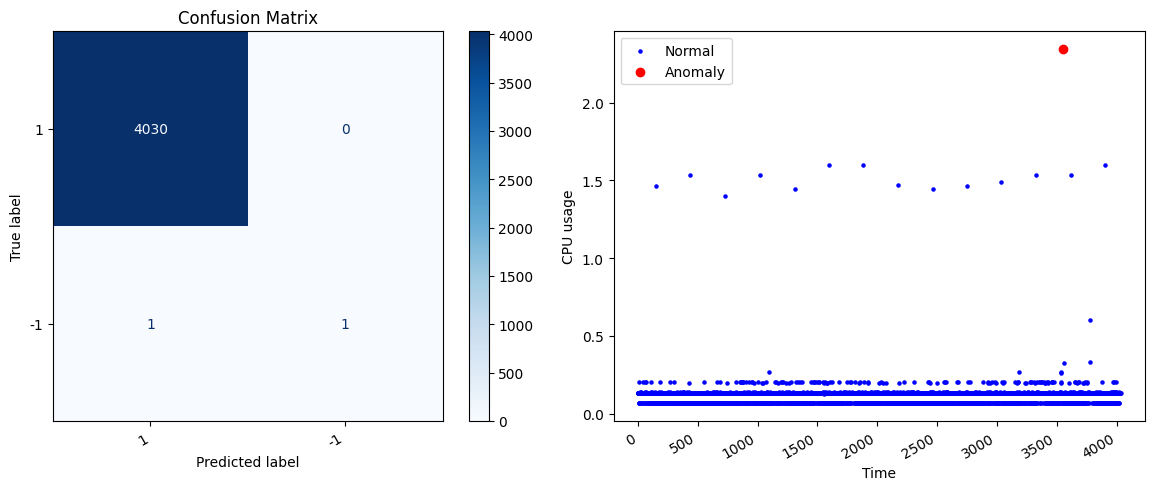

In [15]:
# Split the data (Keep one anomaly in the test set)

contamination = 1/len(df)
iso_forest= IsolationForest(contamination = contamination, random_state=42)

X = df['value'].values.reshape(-1, 1)
iso_forest.fit(X)

preds = iso_forest.predict(X)


anomalies = X[preds == -1]

fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(df['is_anomaly'], preds, labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, -1])
disp_cm.plot(cmap='Blues', ax=ax1[0], values_format='.5g')
ax1[0].set_title('Confusion Matrix')

ax2 = ax1[1]

ax2.scatter(df.index, df['value'], color='blue', s=5, label='Normal')
ax2.scatter(df.index[preds == -1], anomalies, color='red', label='Anomaly')

ax2.set_xlabel('Time')
ax2.set_ylabel('CPU usage')
ax2.legend(loc = 2)

fig.autofmt_xdate()
fig.tight_layout()

plt.show()

## DBSCAN

In [34]:
from sklearn.cluster import DBSCAN

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
X = df["value"].values.reshape(-1, 1)

dbscan = DBSCAN(eps=0.1)
dbscan.fit(X)
set(dbscan.labels_)

{-1, 0, 1}

<Figure size 500x500 with 0 Axes>

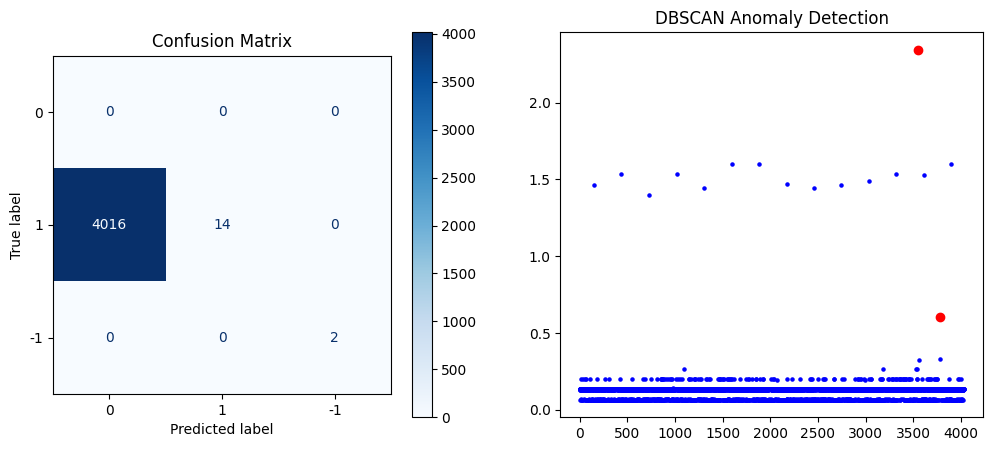

In [49]:
plt.figure (figsize=(5,5))
colors = np.array(['#377eb8' , '#ff7f00', ])
outliers = np.where(dbscan.labels_ == -1, True, False)

# Scatter plot
fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(df['is_anomaly'], dbscan.labels_, labels=[0, 1, -1])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, -1])
disp_cm.plot(cmap='Blues', ax=ax1[0], values_format='.5g')
ax1[0].set_title('Confusion Matrix')

ax2 = ax1[1]

ax2.scatter(df.index, df['value'], color='blue', s=5, label='Normal')
anomaly_indices = df.index[dbscan.labels_ == -1]
anomaly_values = df.loc[dbscan.labels_ == -1, 'value']
ax2.scatter(anomaly_indices, anomaly_values, color='red', label='Anomaly')

plt.title('DBSCAN Anomaly Detection')

plt.show()

